# Imports

In [2]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm import tqdm
import itertools
import pickle
import pandas as pd

# Set random seed for reproducibility
manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) 

Random Seed:  999


In [3]:
# !unzip 'archive.zip'

# Setting up bases

In [4]:
dataroot = "data/Covid19-dataset/train"
workers = 2
ngpu = 1

In [5]:
batch_size = 128
image_size = 64
nc = 3
nz = 100
ngf = 64
ndf = 64
num_epochs = 500
lr = 0.0002
beta1 = 0.5

# Data Loader

In [6]:
def create_dataset(dataroot,image_size,batch_size,workers):
    dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,shuffle=True, num_workers=workers)
    return dataloader

dataloader = create_dataset(dataroot,image_size,batch_size,workers)

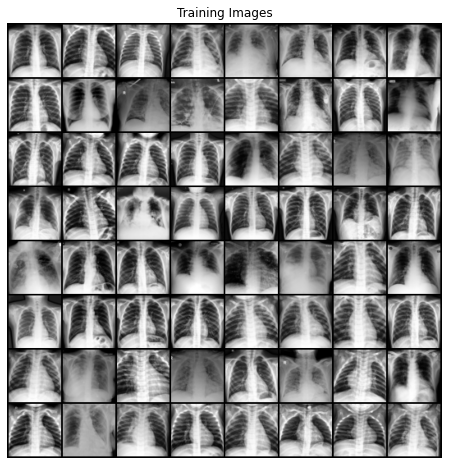

In [7]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

# Weight Initializer

In [8]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Generator for DC-GAN

In [9]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),`
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [10]:
netG = Generator(ngpu).to(device)
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))
netG.apply(weights_init)
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


# Discriminator for DC-GANs

In [11]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [12]:
netD = Discriminator(ngpu).to(device)
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
netD.apply(weights_init)
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


# Criterion Initialization

In [13]:
criterion = nn.BCELoss()
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
real_label = 1.
fake_label = 0.
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [50]:
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()
        netG.zero_grad()
        label.fill_(real_label) 
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/500][0/2]	Loss_D: 1.5075	Loss_G: 4.9536	D(x): 0.5947	D(G(z)): 0.5385 / 0.0124
[1/500][0/2]	Loss_D: 0.1647	Loss_G: 7.1925	D(x): 0.9954	D(G(z)): 0.1376 / 0.0013
[2/500][0/2]	Loss_D: 0.2267	Loss_G: 7.3522	D(x): 0.9873	D(G(z)): 0.1749 / 0.0010
[3/500][0/2]	Loss_D: 0.1206	Loss_G: 7.9716	D(x): 0.9809	D(G(z)): 0.0859 / 0.0006
[4/500][0/2]	Loss_D: 0.2035	Loss_G: 9.4366	D(x): 0.9771	D(G(z)): 0.1488 / 0.0001
[5/500][0/2]	Loss_D: 0.0906	Loss_G: 8.0345	D(x): 0.9784	D(G(z)): 0.0621 / 0.0005
[6/500][0/2]	Loss_D: 0.0461	Loss_G: 9.5748	D(x): 0.9666	D(G(z)): 0.0090 / 0.0001
[7/500][0/2]	Loss_D: 0.1692	Loss_G: 13.0201	D(x): 0.9893	D(G(z)): 0.1350 / 0.0000
[8/500][0/2]	Loss_D: 0.0228	Loss_G: 8.0407	D(x): 0.9851	D(G(z)): 0.0057 / 0.0006
[9/500][0/2]	Loss_D: 0.0600	Loss_G: 17.6219	D(x): 0.9572	D(G(z)): 0.0000 / 0.0000
[10/500][0/2]	Loss_D: 0.0101	Loss_G: 8.6027	D(x): 0.9914	D(G(z)): 0.0011 / 0.0004
[11/500][0/2]	Loss_D: 0.0317	Loss_G: 16.5929	D(x): 0.9727	D(G(z)): 0.0001 / 0.00

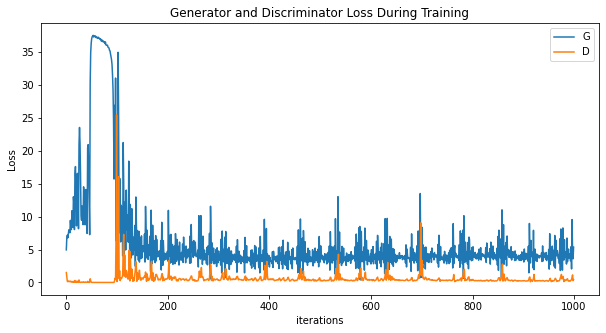

In [52]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

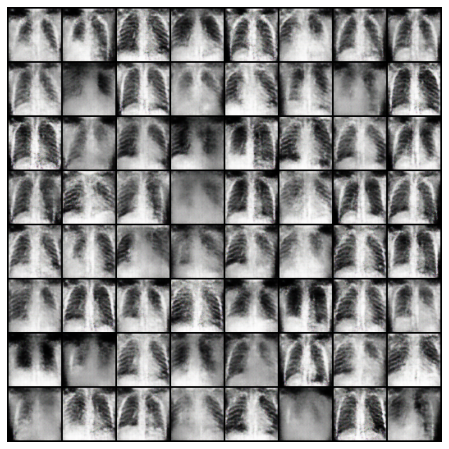

In [53]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

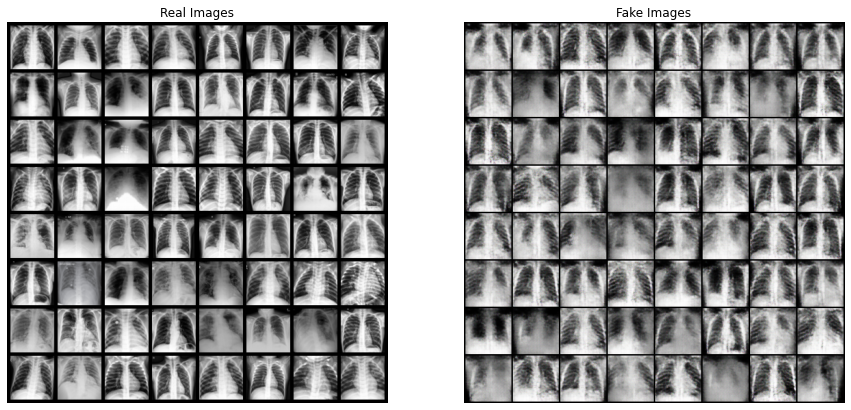

In [54]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [55]:
# Save the final generator and discriminator models
torch.save(netG.state_dict(), 'generator.pth')
torch.save(netD.state_dict(), 'discriminator.pth')

# Hyperparameter Tuning

In [15]:
batch_size = [64,128,256]
image_size = [64]
num_epochs = 250
lr = [0.001,0.01]
beta1 = 0.5


In [15]:
def evaluate_hyperparameters(dataroot,image_size,batch_size,workers,lr):
    dataloader = create_dataset(dataroot,image_size,batch_size,workers
    real_batch = next(iter(dataloader))
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("Training Images")
    plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
    plt.show()
    netG = Generator(ngpu).to(device)
    if (device.type == 'cuda') and (ngpu > 1):
        netG = nn.DataParallel(netG, list(range(ngpu)))
    netG.apply(weights_init)
    netD = Discriminator(ngpu).to(device)
    if (device.type == 'cuda') and (ngpu > 1):
        netD = nn.DataParallel(netD, list(range(ngpu)))
    netD.apply(weights_init)
    criterion = nn.BCELoss()
    fixed_noise = torch.randn(64, nz, 1, 1, device=device)
    real_label = 1.
    fake_label = 0.
    optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
    optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
    img_list = []
    G_losses = []
    D_losses = []
    iters = 0

    print("Starting Training Loop...")
    for epoch in range(num_epochs):
        for i, data in enumerate(dataloader, 0):
            netD.zero_grad()
            real_cpu = data[0].to(device)
            b_size = real_cpu.size(0)
            label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
            output = netD(real_cpu).view(-1)
            errD_real = criterion(output, label)
            errD_real.backward()
            D_x = output.mean().item()
            noise = torch.randn(b_size, nz, 1, 1, device=device)
            fake = netG(noise)
            label.fill_(fake_label)
            output = netD(fake.detach()).view(-1)
            errD_fake = criterion(output, label)
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            errD = errD_real + errD_fake
            optimizerD.step()
            netG.zero_grad()
            label.fill_(real_label)
            output = netD(fake).view(-1)
            errG = criterion(output, label)
            errG.backward()
            D_G_z2 = output.mean().item()
            optimizerG.step()
            if i % 50 == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                      % (epoch, num_epochs, i, len(dataloader),
                         errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            G_losses.append(errG.item())
            D_losses.append(errD.item())
            if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
                with torch.no_grad():
                    fake = netG(fixed_noise).detach().cpu()
                img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            iters += 1
    torch.save(netG.state_dict(), f'generator_{lr}_{batch_size}.pth')
    torch.save(netD.state_dict(), f'discriminator_{lr}_{batch_size}.pth')
    return G_losses, D_losses

The learning rate is:0.001, The Image Size is: 64, The Batch Size is: 64


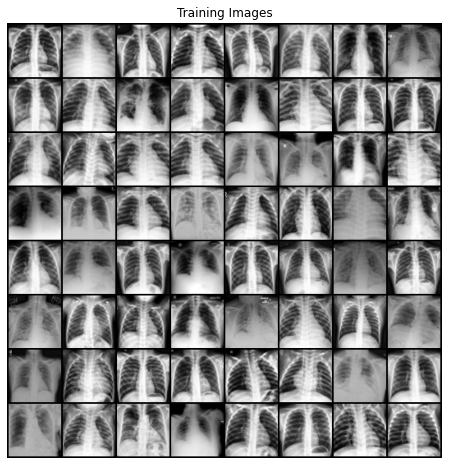

Starting Training Loop...
[0/250][0/4]	Loss_D: 1.5773	Loss_G: 24.7307	D(x): 0.6430	D(G(z)): 0.5941 / 0.0000
[1/250][0/4]	Loss_D: 59.9057	Loss_G: 33.0376	D(x): 0.9993	D(G(z)): 1.0000 / 0.0000
[2/250][0/4]	Loss_D: 1.7611	Loss_G: 33.5190	D(x): 0.9553	D(G(z)): 0.5470 / 0.0000
[3/250][0/4]	Loss_D: 3.0290	Loss_G: 16.5377	D(x): 0.9918	D(G(z)): 0.7019 / 0.0000
[4/250][0/4]	Loss_D: 0.0081	Loss_G: 9.3984	D(x): 0.9993	D(G(z)): 0.0072 / 0.0091
[5/250][0/4]	Loss_D: 0.0187	Loss_G: 12.2923	D(x): 0.9886	D(G(z)): 0.0012 / 0.0012
[6/250][0/4]	Loss_D: 0.0351	Loss_G: 8.0463	D(x): 0.9977	D(G(z)): 0.0310 / 0.0064
[7/250][0/4]	Loss_D: 0.0790	Loss_G: 7.8898	D(x): 0.9734	D(G(z)): 0.0447 / 0.0044
[8/250][0/4]	Loss_D: 0.0401	Loss_G: 5.8556	D(x): 0.9982	D(G(z)): 0.0372 / 0.0125
[9/250][0/4]	Loss_D: 27.8791	Loss_G: 9.0383	D(x): 0.9999	D(G(z)): 0.9892 / 0.0054
[10/250][0/4]	Loss_D: 1.9921	Loss_G: 4.8949	D(x): 0.5418	D(G(z)): 0.0160 / 0.1393
[11/250][0/4]	Loss_D: 0.6872	Loss_G: 1.8589	D(x): 0.8807	D(G(z)): 0.2543 / 

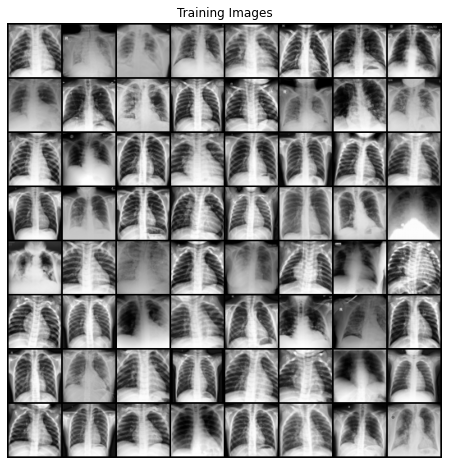

Starting Training Loop...
[0/250][0/2]	Loss_D: 1.1342	Loss_G: 15.9052	D(x): 0.5896	D(G(z)): 0.3556 / 0.0000
[1/250][0/2]	Loss_D: 0.1210	Loss_G: 24.6261	D(x): 0.9652	D(G(z)): 0.0000 / 0.0000
[2/250][0/2]	Loss_D: 2.2141	Loss_G: 40.5131	D(x): 0.4258	D(G(z)): 0.0000 / 0.0000
[3/250][0/2]	Loss_D: 0.0149	Loss_G: 39.8469	D(x): 0.9917	D(G(z)): 0.0000 / 0.0000
[4/250][0/2]	Loss_D: 0.0096	Loss_G: 35.9738	D(x): 0.9937	D(G(z)): 0.0000 / 0.0000
[5/250][0/2]	Loss_D: 39.7798	Loss_G: 26.7712	D(x): 0.9979	D(G(z)): 0.9092 / 0.0000
[6/250][0/2]	Loss_D: 0.8932	Loss_G: 19.1809	D(x): 0.9140	D(G(z)): 0.2466 / 0.0000
[7/250][0/2]	Loss_D: 1.3010	Loss_G: 10.7242	D(x): 0.9819	D(G(z)): 0.5921 / 0.0005
[8/250][0/2]	Loss_D: 0.2202	Loss_G: 7.6572	D(x): 0.9605	D(G(z)): 0.0522 / 0.0104
[9/250][0/2]	Loss_D: 0.1440	Loss_G: 12.1169	D(x): 0.9594	D(G(z)): 0.0020 / 0.0012
[10/250][0/2]	Loss_D: 0.1971	Loss_G: 11.1521	D(x): 0.9517	D(G(z)): 0.0032 / 0.0036
[11/250][0/2]	Loss_D: 0.0431	Loss_G: 7.9117	D(x): 0.9877	D(G(z)): 0.026

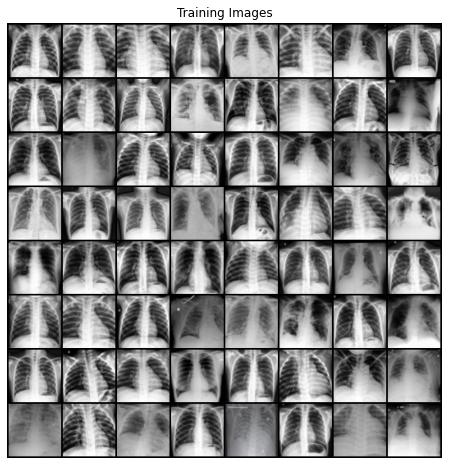

Starting Training Loop...
[0/250][0/1]	Loss_D: 1.2192	Loss_G: 18.1368	D(x): 0.6312	D(G(z)): 0.4372 / 0.0000
[1/250][0/1]	Loss_D: 8.4963	Loss_G: 30.9236	D(x): 0.9993	D(G(z)): 0.9995 / 0.0000
[2/250][0/1]	Loss_D: 0.2958	Loss_G: 25.6979	D(x): 0.9038	D(G(z)): 0.0000 / 0.0000
[3/250][0/1]	Loss_D: 4.7606	Loss_G: 38.9427	D(x): 0.9800	D(G(z)): 0.9444 / 0.0000
[4/250][0/1]	Loss_D: 0.4375	Loss_G: 42.5528	D(x): 0.8914	D(G(z)): 0.0000 / 0.0000
[5/250][0/1]	Loss_D: 0.2494	Loss_G: 42.3302	D(x): 0.9452	D(G(z)): 0.0000 / 0.0000
[6/250][0/1]	Loss_D: 0.1207	Loss_G: 42.0525	D(x): 0.9722	D(G(z)): 0.0000 / 0.0000
[7/250][0/1]	Loss_D: 0.0540	Loss_G: 39.8953	D(x): 0.9843	D(G(z)): 0.0000 / 0.0000
[8/250][0/1]	Loss_D: 0.0141	Loss_G: 33.3237	D(x): 0.9913	D(G(z)): 0.0000 / 0.0000
[9/250][0/1]	Loss_D: 0.0060	Loss_G: 21.7446	D(x): 0.9979	D(G(z)): 0.0037 / 0.0027
[10/250][0/1]	Loss_D: 2.2781	Loss_G: 22.8898	D(x): 0.9990	D(G(z)): 0.6439 / 0.0000
[11/250][0/1]	Loss_D: 0.2715	Loss_G: 18.4509	D(x): 0.9166	D(G(z)): 0.00

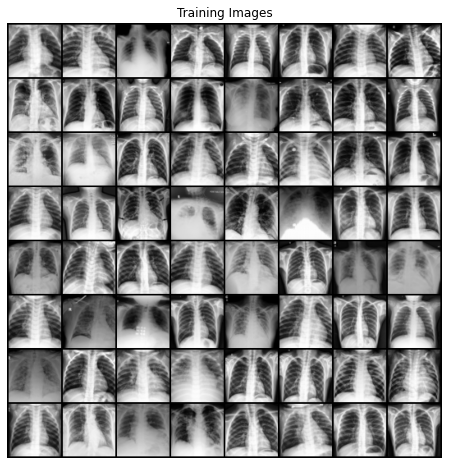

Starting Training Loop...
[0/250][0/4]	Loss_D: 1.4082	Loss_G: 46.1955	D(x): 0.5978	D(G(z)): 0.5004 / 0.0000
[1/250][0/4]	Loss_D: 23.7021	Loss_G: 36.6515	D(x): 0.9895	D(G(z)): 0.5984 / 0.0443
[2/250][0/4]	Loss_D: 52.1177	Loss_G: 15.4011	D(x): 1.0000	D(G(z)): 0.6157 / 0.5336
[3/250][0/4]	Loss_D: 4.1678	Loss_G: 32.5430	D(x): 0.6574	D(G(z)): 0.0878 / 0.0830
[4/250][0/4]	Loss_D: 23.9770	Loss_G: 27.7443	D(x): 0.0023	D(G(z)): 0.0000 / 0.1739
[5/250][0/4]	Loss_D: 10.3262	Loss_G: 43.1192	D(x): 0.8246	D(G(z)): 0.3130 / 0.0000
[6/250][0/4]	Loss_D: 19.1189	Loss_G: 26.8180	D(x): 0.0749	D(G(z)): 0.0000 / 0.0117
[7/250][0/4]	Loss_D: 2.5377	Loss_G: 27.9790	D(x): 0.7747	D(G(z)): 0.1062 / 0.0001
[8/250][0/4]	Loss_D: 2.1103	Loss_G: 25.5645	D(x): 0.8264	D(G(z)): 0.2436 / 0.0000
[9/250][0/4]	Loss_D: 22.8255	Loss_G: 28.0437	D(x): 0.0169	D(G(z)): 0.0000 / 0.0001
[10/250][0/4]	Loss_D: 16.8004	Loss_G: 8.6221	D(x): 0.0199	D(G(z)): 0.0000 / 0.1863
[11/250][0/4]	Loss_D: 5.3521	Loss_G: 0.0459	D(x): 0.4349	D(G(z)):

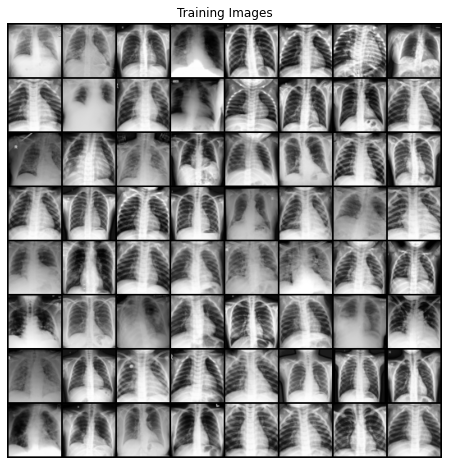

Starting Training Loop...
[0/250][0/2]	Loss_D: 1.3999	Loss_G: 50.2822	D(x): 0.6081	D(G(z)): 0.5070 / 0.0000
[1/250][0/2]	Loss_D: 80.9137	Loss_G: 11.1977	D(x): 1.0000	D(G(z)): 0.9499 / 0.6531
[2/250][0/2]	Loss_D: 52.5323	Loss_G: 18.2966	D(x): 1.0000	D(G(z)): 0.7530 / 0.2660
[3/250][0/2]	Loss_D: 7.8765	Loss_G: 40.9923	D(x): 0.5309	D(G(z)): 0.0083 / 0.0126
[4/250][0/2]	Loss_D: 16.3185	Loss_G: 24.2777	D(x): 0.9433	D(G(z)): 0.5519 / 0.0096
[5/250][0/2]	Loss_D: 8.6384	Loss_G: 33.7926	D(x): 0.8662	D(G(z)): 0.2424 / 0.0000
[6/250][0/2]	Loss_D: 2.5435	Loss_G: 36.7007	D(x): 0.7131	D(G(z)): 0.0000 / 0.0003
[7/250][0/2]	Loss_D: 32.7668	Loss_G: 22.3799	D(x): 0.9765	D(G(z)): 0.5148 / 0.0905
[8/250][0/2]	Loss_D: 26.3708	Loss_G: 21.8704	D(x): 0.0000	D(G(z)): 0.0000 / 0.0295
[9/250][0/2]	Loss_D: 11.0664	Loss_G: 39.1276	D(x): 0.9170	D(G(z)): 0.6166 / 0.0000
[10/250][0/2]	Loss_D: 40.9023	Loss_G: 4.8993	D(x): 0.9013	D(G(z)): 0.7486 / 0.5925
[11/250][0/2]	Loss_D: 14.5416	Loss_G: 36.9165	D(x): 0.8065	D(G(z)

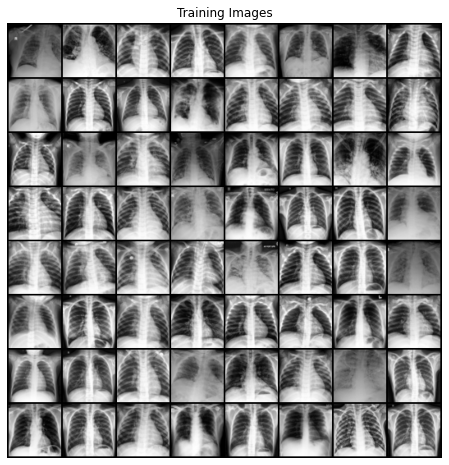

Starting Training Loop...
[0/250][0/1]	Loss_D: 2.1825	Loss_G: 57.8148	D(x): 0.6144	D(G(z)): 0.7451 / 0.0000
[1/250][0/1]	Loss_D: 16.6607	Loss_G: 3.2350	D(x): 0.0020	D(G(z)): 0.0000 / 0.4390
[2/250][0/1]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[3/250][0/1]	Loss_D: 97.5882	Loss_G: 12.7175	D(x): 1.0000	D(G(z)): 1.0000 / 0.3390
[4/250][0/1]	Loss_D: 80.4662	Loss_G: 8.3430	D(x): 1.0000	D(G(z)): 0.9595 / 0.4840
[5/250][0/1]	Loss_D: 31.3560	Loss_G: 44.4305	D(x): 1.0000	D(G(z)): 0.5665 / 0.0076
[6/250][0/1]	Loss_D: 9.2104	Loss_G: 61.6839	D(x): 0.9863	D(G(z)): 0.2225 / 0.0000
[7/250][0/1]	Loss_D: 2.6159	Loss_G: 54.3296	D(x): 0.7991	D(G(z)): 0.0008 / 0.0001
[8/250][0/1]	Loss_D: 4.9061	Loss_G: 46.4940	D(x): 0.8496	D(G(z)): 0.2827 / 0.0000
[9/250][0/1]	Loss_D: 2.0350	Loss_G: 34.9128	D(x): 0.8307	D(G(z)): 0.0140 / 0.0169
[10/250][0/1]	Loss_D: 3.5009	Loss_G: 26.3864	D(x): 0.9114	D(G(z)): 0.1165 / 0.0453
[11/250][0/1]	Loss_D: 15.2295	Loss_G: 28.8638	D(x): 0.9231	D(G(z)): 

In [17]:
results = []
for lr1, ims, bs in itertools.product(lr, image_size, batch_size):
    print(f"The learning rate is:{lr1}, The Image Size is: {ims}, The Batch Size is: {bs}")
    g1,d1 = evaluate_hyperparameters(dataroot,ims,bs,workers,lr1)
    results.append({
        'lr': lr1,
        'image_size': ims,
        'batch_size': bs,
        'avg_G_loss': sum(g1) / len(g1),
        'avg_D_loss': sum(d1) / len(d1),
        'g_loss': g1,
        'd_loss':d1
    })


In [18]:
file_path = 'data.pkl'with open(file_path, 'wb') as file:
    pickle.dump(results, file)
print("Array of dictionaries saved as pickle file successfully!")

Array of dictionaries saved as pickle file successfully!


In [19]:
with open(file_path, 'rb') as file:
    loaded_array_of_dicts = pickle.load(file)
print("Array of dictionaries loaded from pickle file:", loaded_array_of_dicts)

Array of dictionaries loaded from pickle file: [{'lr': 0.001, 'image_size': 64, 'batch_size': 64, 'avg_G_loss': 3.2638678529262544, 'avg_D_loss': 1.3239122622199357, 'g_loss': [24.73073387145996, 32.66132354736328, 31.569290161132812, 15.676909446716309, 33.03762435913086, 34.27519989013672, 27.53534698486328, 18.855024337768555, 33.519004821777344, 26.500919342041016, 14.980398178100586, 8.90829849243164, 16.537723541259766, 16.404014587402344, 14.781486511230469, 10.796372413635254, 9.39842414855957, 16.62416648864746, 13.409666061401367, 12.45985221862793, 12.292315483093262, 11.381952285766602, 9.956535339355469, 8.038066864013672, 8.046269416809082, 9.114327430725098, 8.979625701904297, 7.55575704574585, 7.8898210525512695, 9.101211547851562, 10.284814834594727, 9.48180866241455, 5.8556294441223145, 13.542398452758789, 11.327744483947754, 1.0552891492843628, 9.038288116455078, 1.1758630275726318, 4.486597061157227, 9.420809745788574, 4.894918441772461, 6.264487266540527, 14.661364

In [27]:
def graph_plotter(g_l,d_l,lr,bs):
    plt.figure(figsize=(10,5))
    plt.title(f"Generator and Discriminator Loss During Training for Learning Rate - {lr} and Batch Size - {bs}")
    plt.plot(g_l,label="G")
    plt.plot(d_l,label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    plt.savefig(f'Generator and Discriminator Loss During Training for Learning Rate - {lr} and Batch Size - {bs}.png')

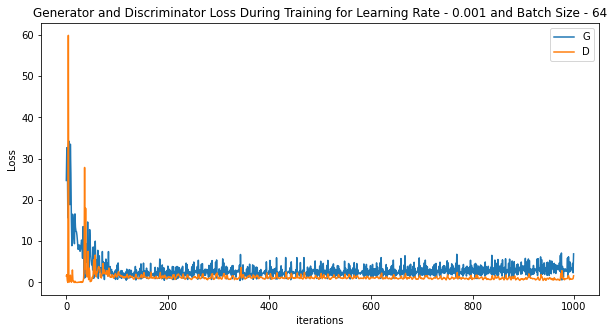

<Figure size 432x288 with 0 Axes>

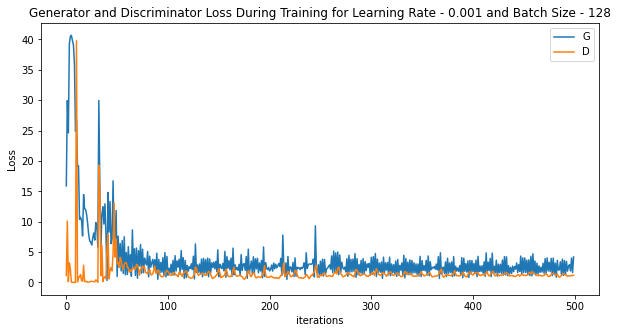

<Figure size 432x288 with 0 Axes>

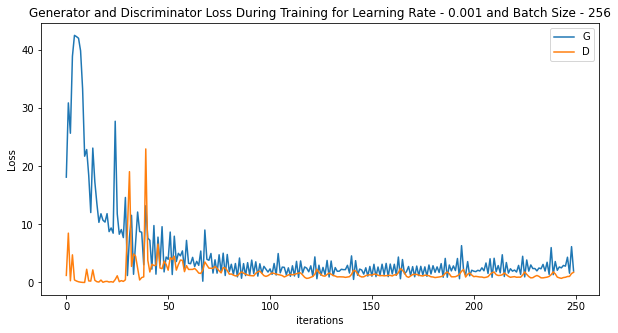

<Figure size 432x288 with 0 Axes>

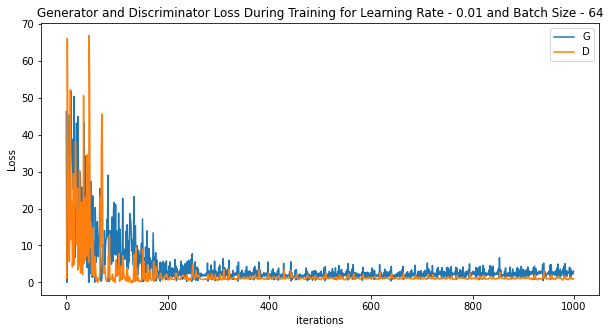

<Figure size 432x288 with 0 Axes>

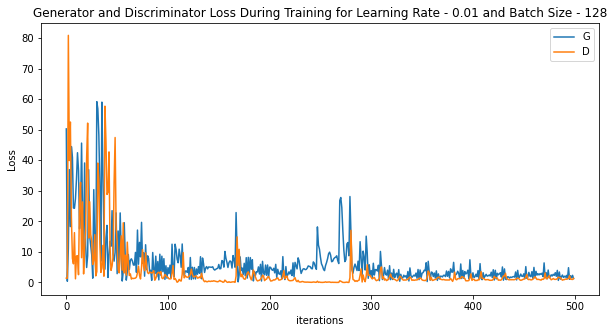

<Figure size 432x288 with 0 Axes>

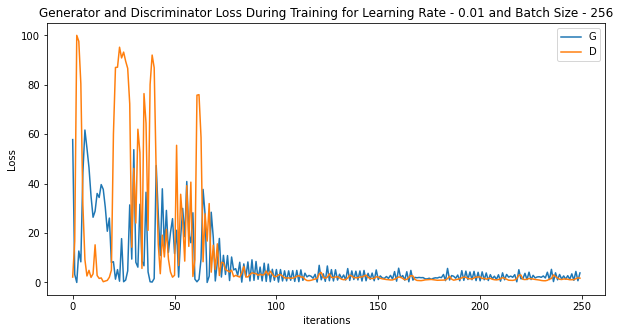

<Figure size 432x288 with 0 Axes>

In [28]:
for i in range(6):
    graph_plotter(loaded_array_of_dicts[i]['g_loss'],loaded_array_of_dicts[i]['d_loss'],loaded_array_of_dicts[i]['lr'],loaded_array_of_dicts[i]['batch_size'])

In [29]:
netG = Generator(ngpu).to(device)
netG.load_state_dict(torch.load('generator_0.001_128.pth'))
netD = Discriminator(ngpu).to(device)
netD.load_state_dict(torch.load('discriminator_0.001_128.pth'))

<All keys matched successfully>

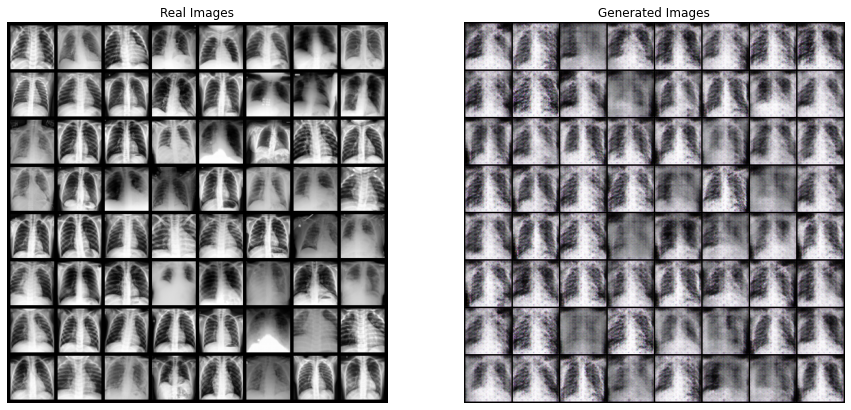

In [33]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(vutils.make_grid(fake_images, padding=2, normalize=True), (1, 2, 0)))
plt.show()

In [ ]:
def comparative_plotter():
    netG = Generator(ngpu).to(device)
    netG.load_state_dict(torch.load('generator_0.001_128.pth'))
    netD = Discriminator(ngpu).to(device)
    netD.load_state_dict(torch.load('discriminator_0.001_128.pth'))

The learning rate is:0.001, The Image Size is: 64, The Batch Size is: 64


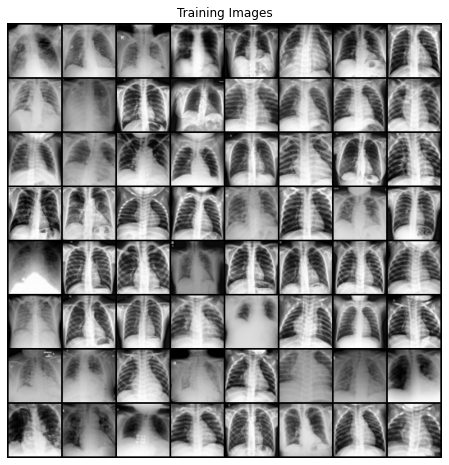

Starting Training Loop...
[0/500][0/4]	Loss_D: 2.1591	Loss_G: 29.4654	D(x): 0.8162	D(G(z)): 0.8022 / 0.0000
[1/500][0/4]	Loss_D: 0.2501	Loss_G: 36.2109	D(x): 0.9417	D(G(z)): 0.0000 / 0.0000
[2/500][0/4]	Loss_D: 0.0338	Loss_G: 22.3304	D(x): 0.9814	D(G(z)): 0.0000 / 0.0000
[3/500][0/4]	Loss_D: 0.0035	Loss_G: 20.0088	D(x): 0.9989	D(G(z)): 0.0024 / 0.0045
[4/500][0/4]	Loss_D: 0.0450	Loss_G: 9.1554	D(x): 0.9806	D(G(z)): 0.0109 / 0.0009
[5/500][0/4]	Loss_D: 0.2923	Loss_G: 11.0598	D(x): 0.9416	D(G(z)): 0.0006 / 0.0017
[6/500][0/4]	Loss_D: 0.6970	Loss_G: 8.5708	D(x): 0.9036	D(G(z)): 0.2541 / 0.0421
[7/500][0/4]	Loss_D: 0.3766	Loss_G: 8.0903	D(x): 0.9695	D(G(z)): 0.1487 / 0.0112
[8/500][0/4]	Loss_D: 9.0764	Loss_G: 5.9616	D(x): 0.9985	D(G(z)): 0.4873 / 0.0678
[9/500][0/4]	Loss_D: 2.5692	Loss_G: 6.5885	D(x): 0.9658	D(G(z)): 0.6067 / 0.0486
[10/500][0/4]	Loss_D: 1.9755	Loss_G: 1.9164	D(x): 0.4849	D(G(z)): 0.1085 / 0.3114
[11/500][0/4]	Loss_D: 1.5816	Loss_G: 3.6860	D(x): 0.6260	D(G(z)): 0.2325 / 0.

In [17]:
final_res = []
num_epochs=500
lr = [0.001]
batch_size=[64]
image_size=[64]
for lr1, ims, bs in itertools.product(lr, image_size, batch_size):
    print(f"The learning rate is:{lr1}, The Image Size is: {ims}, The Batch Size is: {bs}")
    g1,d1 = evaluate_hyperparameters(dataroot,ims,bs,workers,lr1)
    final_res.append({
        'lr': lr1,
        'image_size': ims,
        'batch_size': bs,
        'avg_G_loss': sum(g1) / len(g1),
        'avg_D_loss': sum(d1) / len(d1),
        'g_loss': g1,
        'd_loss':d1
    })

In [20]:
file_path = 'data.pkl'
with open(file_path, 'rb') as file:
    loaded_array_of_dicts = pickle.load(file)
print("Array of dictionaries loaded from pickle file:", loaded_array_of_dicts)

Array of dictionaries loaded from pickle file: [{'lr': 0.001, 'image_size': 64, 'batch_size': 64, 'avg_G_loss': 3.2638678529262544, 'avg_D_loss': 1.3239122622199357, 'g_loss': [24.73073387145996, 32.66132354736328, 31.569290161132812, 15.676909446716309, 33.03762435913086, 34.27519989013672, 27.53534698486328, 18.855024337768555, 33.519004821777344, 26.500919342041016, 14.980398178100586, 8.90829849243164, 16.537723541259766, 16.404014587402344, 14.781486511230469, 10.796372413635254, 9.39842414855957, 16.62416648864746, 13.409666061401367, 12.45985221862793, 12.292315483093262, 11.381952285766602, 9.956535339355469, 8.038066864013672, 8.046269416809082, 9.114327430725098, 8.979625701904297, 7.55575704574585, 7.8898210525512695, 9.101211547851562, 10.284814834594727, 9.48180866241455, 5.8556294441223145, 13.542398452758789, 11.327744483947754, 1.0552891492843628, 9.038288116455078, 1.1758630275726318, 4.486597061157227, 9.420809745788574, 4.894918441772461, 6.264487266540527, 14.661364